# Community Detection

This notebook is a modified version of the notebook from [Chapter 5 of Mining Complex Networks](https://github.com/ftheberge/GraphMiningNotebooks/blob/master/Julia_Notebooks_2nd/Chapter_5.ipynb). In this notebook, we explore several algorithms to find communities in graphs. Due to the rich ecosystem of python implementations for community detection algorithms, we use PythonCall to allow us to access these implementations.

In some cells, we use the ABCD benchmark to generate synthetic graphs with communities installed from https://github.com/bkamins/ABCDGraphGenerator.jl

In [1]:
using PythonCall

In [2]:
ig = pyimport("igraph")
ig_part = pyimport("partition_igraph")

Python: <module 'partition_igraph' from '/Users/ryandewolfe/2026_MIT_18.S097_Introduction-to-Julia-for-Data-Science/.CondaPkg/.pixi/envs/default/lib/python3.10/site-packages/partition_igraph/__init__.py'>

In [3]:
using ABCDGraphGenerator
using CSV, DataFrames
using Clustering
using DelimitedFiles
using Graphs
using GraphMakie, GLMakie
using NetworkLayout
using Plots
using Random
using Serialization
using StatsBase
using StatsPlots

# Zachary (karate) graph

This is a small graph with 34 nodes and two ground-truth communities.
Modularity-based algorithms will typically find 4 or 5 communities.
In the next cells, we look at this small graph from several different angles.


In [31]:
g_karate = smallgraph(:karate)
karate_comms = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2];

In [32]:
## plot graph without axes and background grid
function clean_graphplot(g::AbstractGraph; kwargs...)
    f, ax, p = graphplot(g; kwargs...)
    hidedecorations!(ax)
    hidespines!(ax)
    return f
end

clean_graphplot (generic function with 1 method)

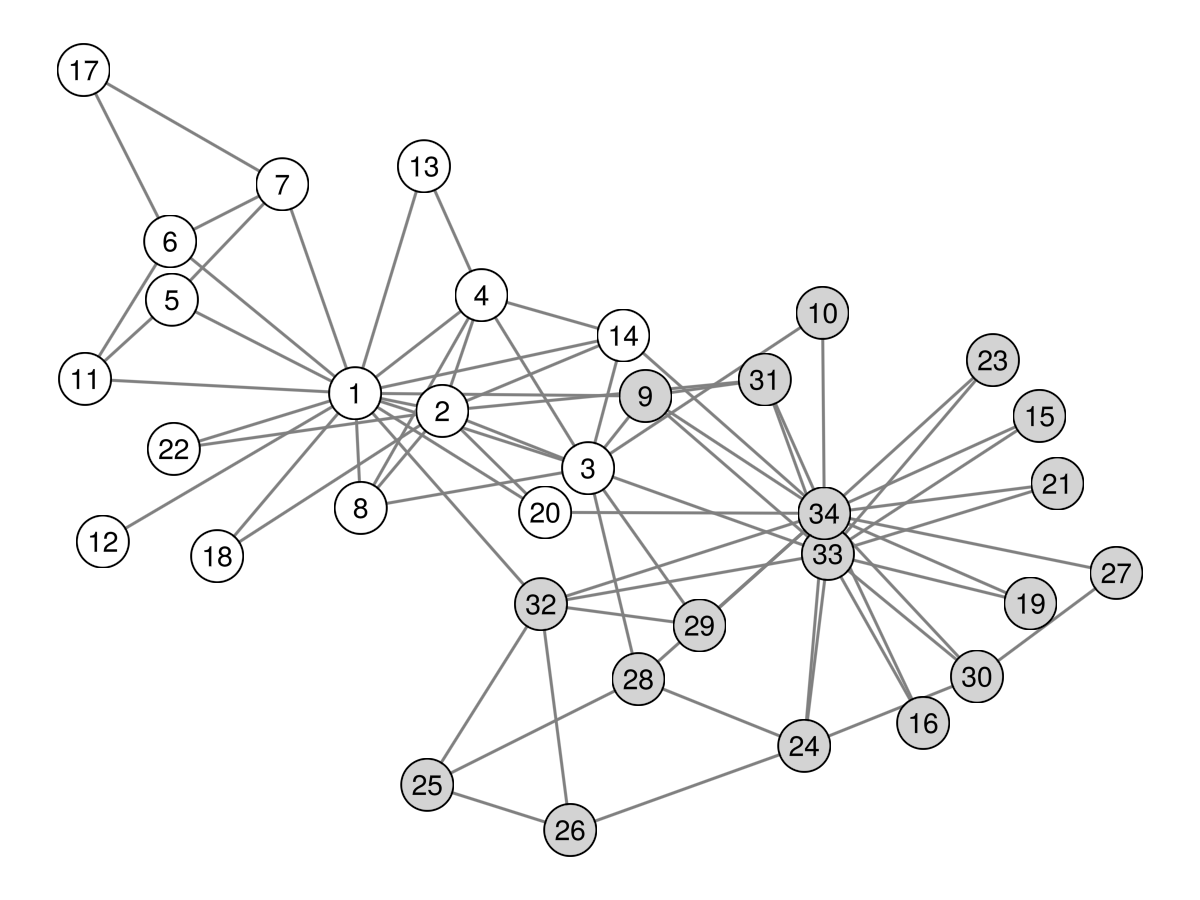

In [33]:
clean_graphplot(g_karate,
    layout=Stress(),
    node_size=25,
    ilabels=repr.(1:nv(g_karate)),
    node_color=[:white, :lightgray][karate_comms],
    edge_color=:grey)

## Node Roles
 
We compute $z(v)$ (normalized within module degree) and $p(v)$ (participation coefficients) as defined in section 5.2 of the book for the Zachary graph `g_zac`. 

We identify 3 types of nodes, as described in the book.

* provincial hubs
* peripheral nodes (non-hubs)
* ultra peripheral nodes (non-hubs)

In [34]:
## normalized within-module degree (z(v))
function nwmd(g::SimpleGraph, a::Vector{Int})
    # within module degrees
    deg_in = [sum([a[v] == a[i] for i in neighbors(g, v)]) for v in 1:nv(g)]
    deg_in_mean = [mean([deg_in[i] for i in 1:nv(g) if a[i] == j]) for j in Set(a)]
    deg_in_std = [std([deg_in[i] for i in 1:nv(g) if a[i] == j]) for j in Set(a)]
    return [(deg_in[v] - deg_in_mean[a[v]]) / deg_in_std[a[v]] for v in 1:nv(g)]
end

## participation coefficient
function pc(g::SimpleGraph, a::Vector{Int})
    deg = degree(g)
    coef = Float64[]
    for v in 1:nv(g)
        nbhs_comm_count = values(countmap(a[neighbors(g, v)]))
        push!(coef, 1 - sum(x -> (x / deg[v])^2, nbhs_comm_count))
    end
    return coef
end

pc (generic function with 1 method)

In [35]:
## compute z (normalized within-module degree) and p (participation coefficient)
karate_z = nwmd(g_karate, karate_comms)
karate_p = pc(g_karate, karate_comms);

### Looking at $z(v)$ and $p(v)$

Below, we plot the Zachary graph with respect to $z(v)$ where $z(v) > 2.5$ are **hubs**, which we show as **white square** nodes.

The largest values are for node 0 (instructor), node 33 (president) and node 32.
Nodes 0 and 33 are the key nodes for the division of the group into factions.

The **ultra-peripherial** nodes are shown with darker color.

In [36]:
karate_color = Symbol[]
karate_marker = fill(:circle, nv(g_karate))
for v in vertices(g_karate)
    if karate_z[v] < 2.5
        ## peripheral
        karate_p[v] < 0.62 && karate_p[v] >= 0.05 && push!(karate_color, :white)
        ## ultra-peripheral
        karate_p[v] < 0.05 && push!(karate_color, :lightgray)
    end
    ## hubs (all provincial here)
    if karate_z[v] >= 2.5 && karate_p[v] < 0.3
        push!(karate_color, :white)
        karate_marker[v] = :rect
    end
end

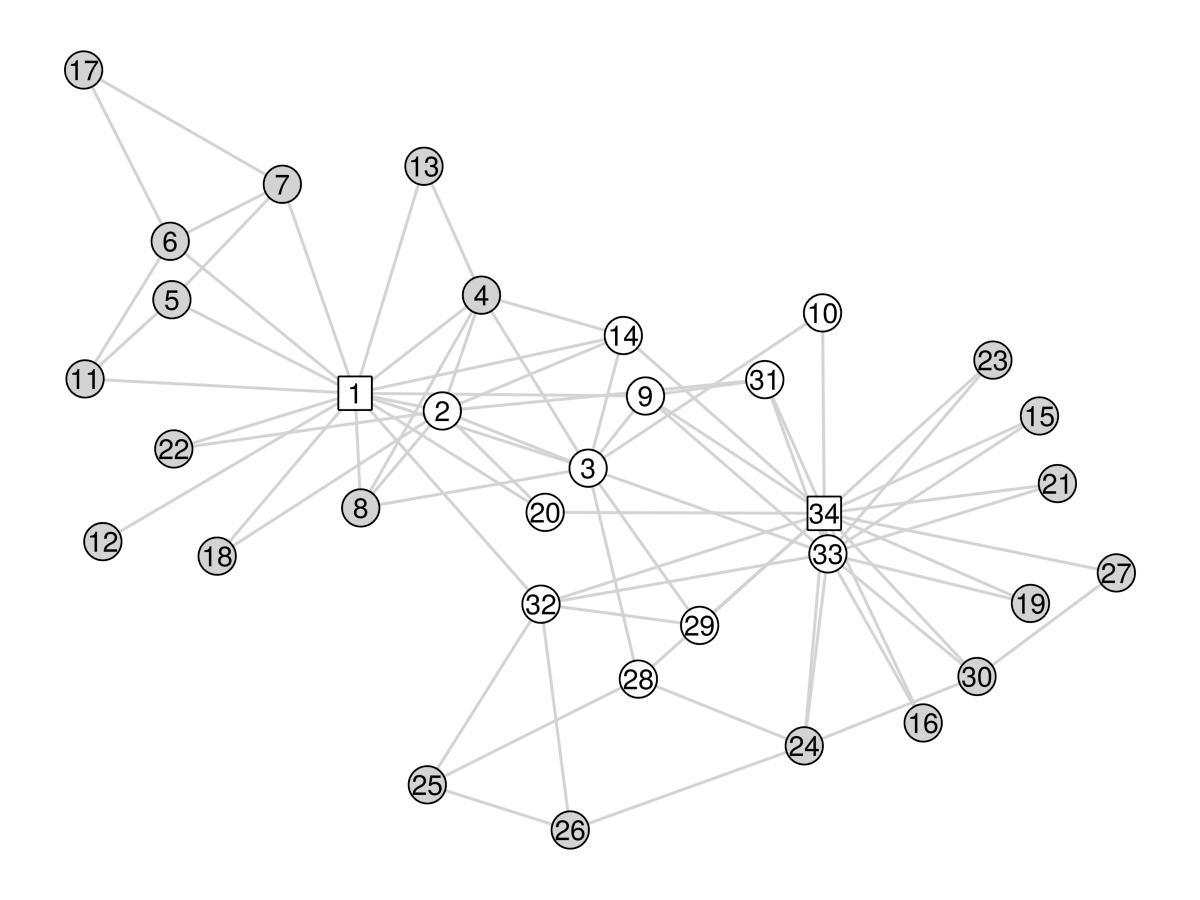

In [37]:
clean_graphplot(g_karate,
    layout=Stress(),
    node_size=25,
    node_marker=karate_marker,
    ilabels=repr.(1:nv(g_karate)),
    node_color=karate_color,
    edge_color=:lightgrey
)

### Figure 5.3(b)

The code below is to generate Figure 5.3(b) in the book, again comparing node roles in the Zachary graph.


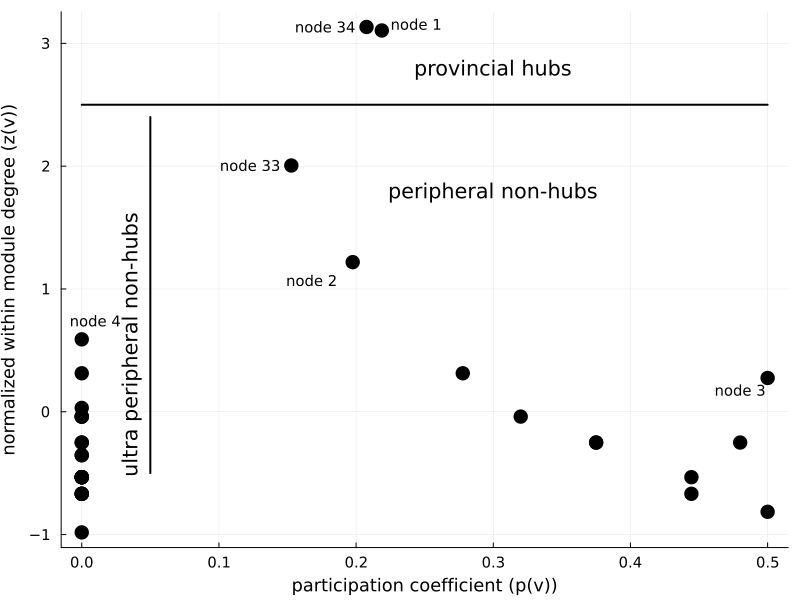

In [38]:
## Figure 5.3(b) -- comparing the roles
p = Plots.scatter(karate_p, karate_z, 
    markersize = 8, 
    color = :black, 
    markerstrokewidth = 0,
    label = "", 
    size = (800, 600),
    xlabel = "participation coefficient (p(v))",
    ylabel = "normalized within module degree (z(v))",
    guidefontsize = 12,
    tickfontsize = 10
)
Plots.plot!([0, 0.5], [2.5, 2.5], color=:black, lw=2, label="")
Plots.plot!([0.05, 0.05], [-0.5, 2.4], color=:black, lw=2, label="")
nodes_to_label = [
    (1, :bottom, (0.025, 0.05)),
    (34, :bottom, (-0.03, 0.)),
    (33, :right, (-0.03, 0.0)),
    (2, :bottom, (-0.03, -0.15)),
    (4, :bottom, (0.01, 0.15)),
    (3, :bottom, (-0.02, -0.1))
]

for (idx, align, offset) in nodes_to_label
    annotate!(karate_p[idx] + offset[1], karate_z[idx] + offset[2], 
              Plots.text("node $idx", 10, :black))
end

annotate!(0.3, 2.8, Plots.text("provincial hubs", 14, :black))
annotate!(0.3, 1.8, Plots.text("peripheral non-hubs", 14, :black))
annotate!(0.035, 0.55, Plots.text("ultra peripheral non-hubs", 14, :black,rotation = 90))

### Looking at a few other community-based features

We already saw the *normalized within-module degree* $z(v)$ and *participation coefficient* $p(v)$.

Recall that a high value for $z(v)$ is indicative of a hub. 

For $p(v)$, a value close to zero indicates homogeneity of communities amongst $v$'s neighbours, while a high value indicates heterogeneity.

Below we compute the *community distribution distance* (cdd) and the *community association strength* (cas).

In [42]:
# community distribution distance
function cdd(g::Graph, a::Vector{Int})
    deg = degree(g)
    vol = sum(deg)
    max_comm = maximum(a)
    vol_a = zeros(Float64, max_comm + 1)

    for i in 1:nv(g)
        vol_a[a[i]+1] += deg[i]
    end
    vol_a ./= vol

    cdd_values = []
    for i in 1:nv(g)
        deg_a = zeros(Float64, max_comm + 1)
        for v in neighbors(g, i)
            deg_a[a[v]+1] += 1
        end
        push!(cdd_values, sqrt(sum((deg_a ./ deg[i] .- vol_a) .^ 2)))
    end
    return cdd_values
end

# community association strength
function cas(g::Graph, a::Vector{Int})
    deg = degree(g)
    deg_int = [sum(a[i] == a[j] for i in neighbors(g, j)) for j in 1:nv(g)]
    vol = sum(deg)
    max_comm = maximum(a)
    vol_a = zeros(Float64, max_comm + 1)

    for i in 1:nv(g)
        vol_a[a[i]+1] += deg[i]
    end

    return [deg_int[i] / deg[i] - (vol_a[a[i]+1] - deg[i]) / vol for i in 1:nv(g)]
end

cas (generic function with 1 method)

In [43]:
karate_cdd = cdd(g_karate, karate_comms)
karate_cas = cas(g_karate, karate_comms);

Below we show the nodes with low *cas* values with white color. We see that those correspond to nodes that are at the boundary between communities.

We also compute the Pearson correlation coefficient between the community-based measures we computed.


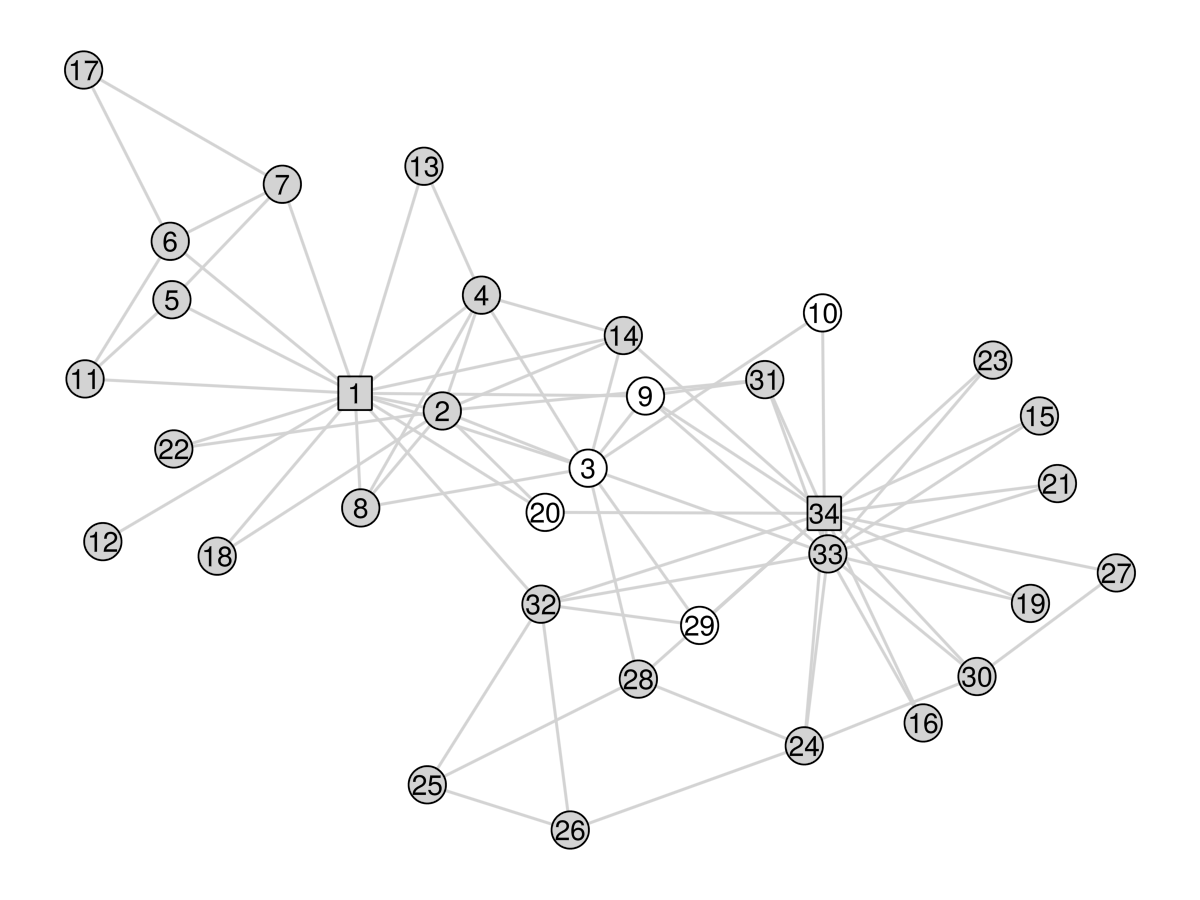

In [44]:
## value with lowest 'cas' are shown in white
th = quantile(karate_cas, 0.15)
karate_plot = clean_graphplot(g_karate,
    layout=Stress(),
    node_size=25,
    node_marker=karate_marker,
    ilabels=repr.(1:nv(g_karate)),
    node_color=[:white, :lightgrey][Int.(karate_cas .> th).+1],
    edge_color=:lightgrey
)

In [45]:
## correlation between various community-based measures
cor(Float64.([karate_z karate_p karate_cdd karate_cas]))

4×4 Matrix{Float64}:
  1.0         0.138623  -0.0454809   0.115742
  0.138623    1.0       -0.975694   -0.945899
 -0.0454809  -0.975694   1.0         0.986077
  0.115742   -0.945899   0.986077    1.0

## Strong and weak communities

Communities can be defined as strong or weak as per (5.1) and (5.2) in the book.

For the Zachary graph, we verify if nodes within communities satisfy the strong criterion, then we verify if the two communities satisfy the weak definition.

For the strong definition (internal degree larger than external degree for each node), only two nodes do not qualify: nodes 3 and 10.

For the weak definition (total community internal degree > total community external degree), both communities satisfy this criterion.


In [16]:
## strong criterion
for i in vertices(g_karate)
    c = karate_comms[i]
    n = [karate_comms[v] == c for v in neighbors(g_karate, i)]
    if sum(n) <= length(n) - sum(n)
        println("node $(i) has internal degree $(sum(n)) external degree $(length(n)-sum(n))")
    end
end

node 3 has internal degree 5 external degree 5
node 10 has internal degree 1 external degree 1


In [17]:
## weak criterion
i_vec = [0, 0]
e = [0, 0]
for i in vertices(g_karate)
    c = karate_comms[i]
    n = [karate_comms[v] == c for v in neighbors(g_karate, i)]
    i_vec[c] += sum(n)
    e[c] += length(n) - sum(n)
end
println("community 1 internal degree $(i_vec[1]) external degree $(e[1])")
println("community 2 internal degree $(i_vec[2]) external degree $(e[2])")

community 1 internal degree 66 external degree 10
community 2 internal degree 70 external degree 10


# Run a community detection algorithm

There are many existing algorithms for automatically detecting communities in graphs, some of which we will see in the next section. However, not every algorithm has a standard Julia implementation (there are some pull requests working in progress in Graphs.jl right now), so we will call on python implementations of these algorithms.

The conversion can be tricky, so let's first see how it works on the Karate club graph.

In [18]:
# edges(g_karate) does not work, build a list of edges manually
e = Vector{Tuple{Int64, Int64}}()
for i in vertices(g_karate)
    for v in outneighbors(g_karate, i)
        if i > v
            push!(e, (i-1,v-1)) # python uses 0 indexing
        end
    end
end

In [19]:
# Construct a python igraph object with the karate graph information. We will use uppercase G to denote a python graph object
G = ig.Graph()
G.add_vertices(nv(g_karate))
G.add_edges(e)
# Run the Leiden community detection algorithm and convert the resulting vector back to a Julia object.
ecg_karate_comms = pyconvert(Vector, G.community_leiden(objective_function="modularity").membership)
ecg_karate_comms = ecg_karate_comms .+ 1 # converted vector is 0 indexed

34-element Vector{Int64}:
 1
 1
 1
 1
 2
 2
 2
 1
 3
 1
 2
 1
 1
 ⋮
 3
 4
 4
 4
 3
 4
 4
 3
 3
 4
 3
 3

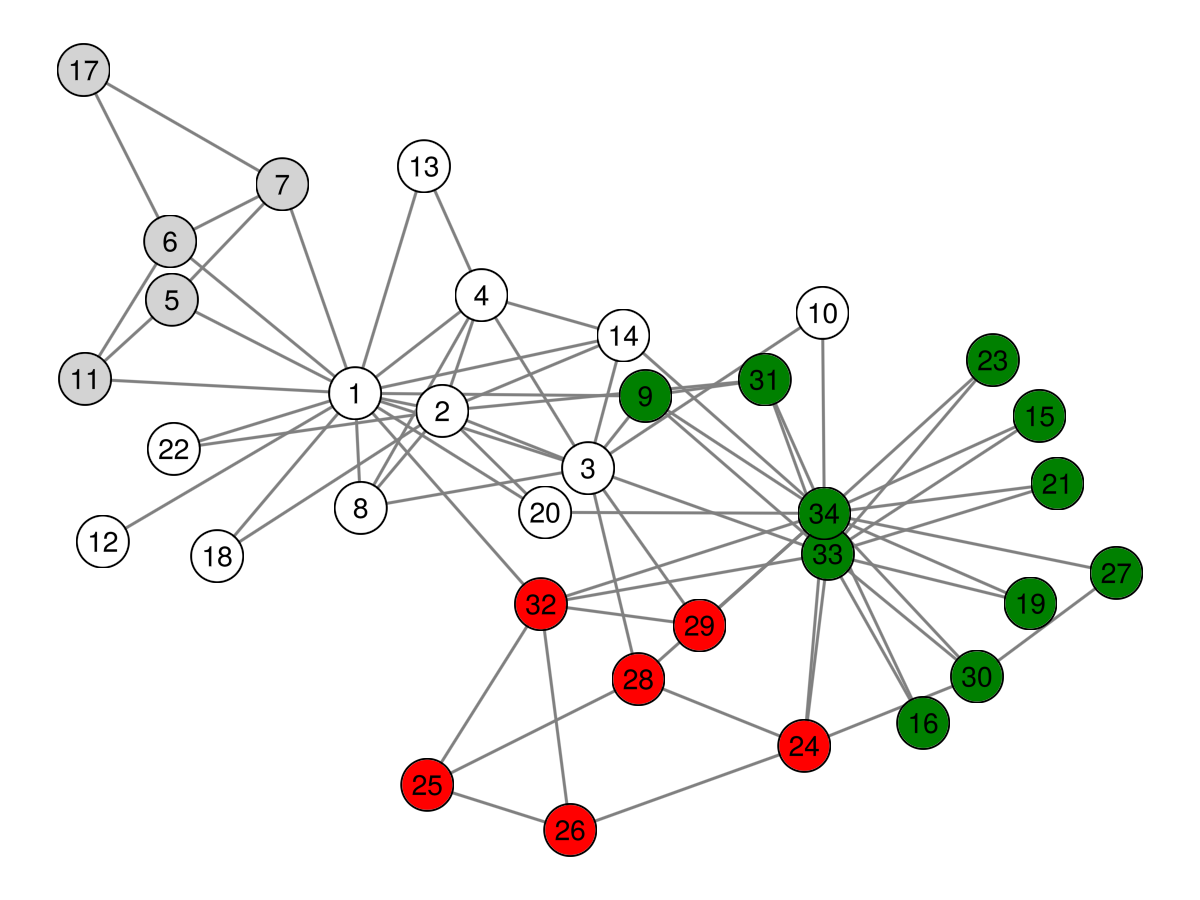

In [20]:
clean_graphplot(g_karate,
    layout=Stress(),
    node_size=25,
    ilabels=repr.(1:nv(g_karate)),
    node_color=[:white, :lightgray, :green, :red][ecg_karate_comms],
    edge_color=:grey)

# ABCD graph with 100 nodes

Next we look at a slightly larger graph generated with the ABCD benchmark model, which is described in section 5.3 of the book. This graph has 3 communities. 
Using hierarchical clustering, we compare modularity and AMI for each possible cut.

The ABCD parameters used to generate this graph are: 
* $\gamma=3$
* degree range [5,15]
* $\tau=2$
* community size range [25,50]

* $\xi$ varies (see figure).

In [21]:
## ABCD with varying community strength (xi)
n = 100

## degrees
gamma = 3
delta = 5
Delta = 15

## communities
beta = 2
s = 25
S = 50

XIs = [0.05, 0.15, 0.33, 0.5]
g_abcds_xi = []
for xi in XIs
    Random.seed!(42)
    degs = ABCDGraphGenerator.sample_degrees(gamma, delta, Delta, n, 1000)
    coms = ABCDGraphGenerator.sample_communities(beta, s, S, n, 1000)
    p = ABCDGraphGenerator.ABCDParams(degs, coms, nothing, xi, false, false, false)
    edges, clusters = ABCDGraphGenerator.gen_graph(p)
    g = SimpleGraph(n)
    for row in edges
        add_edge!(g, row...)
    end
    push!(g_abcds_xi, (g, clusters))
end

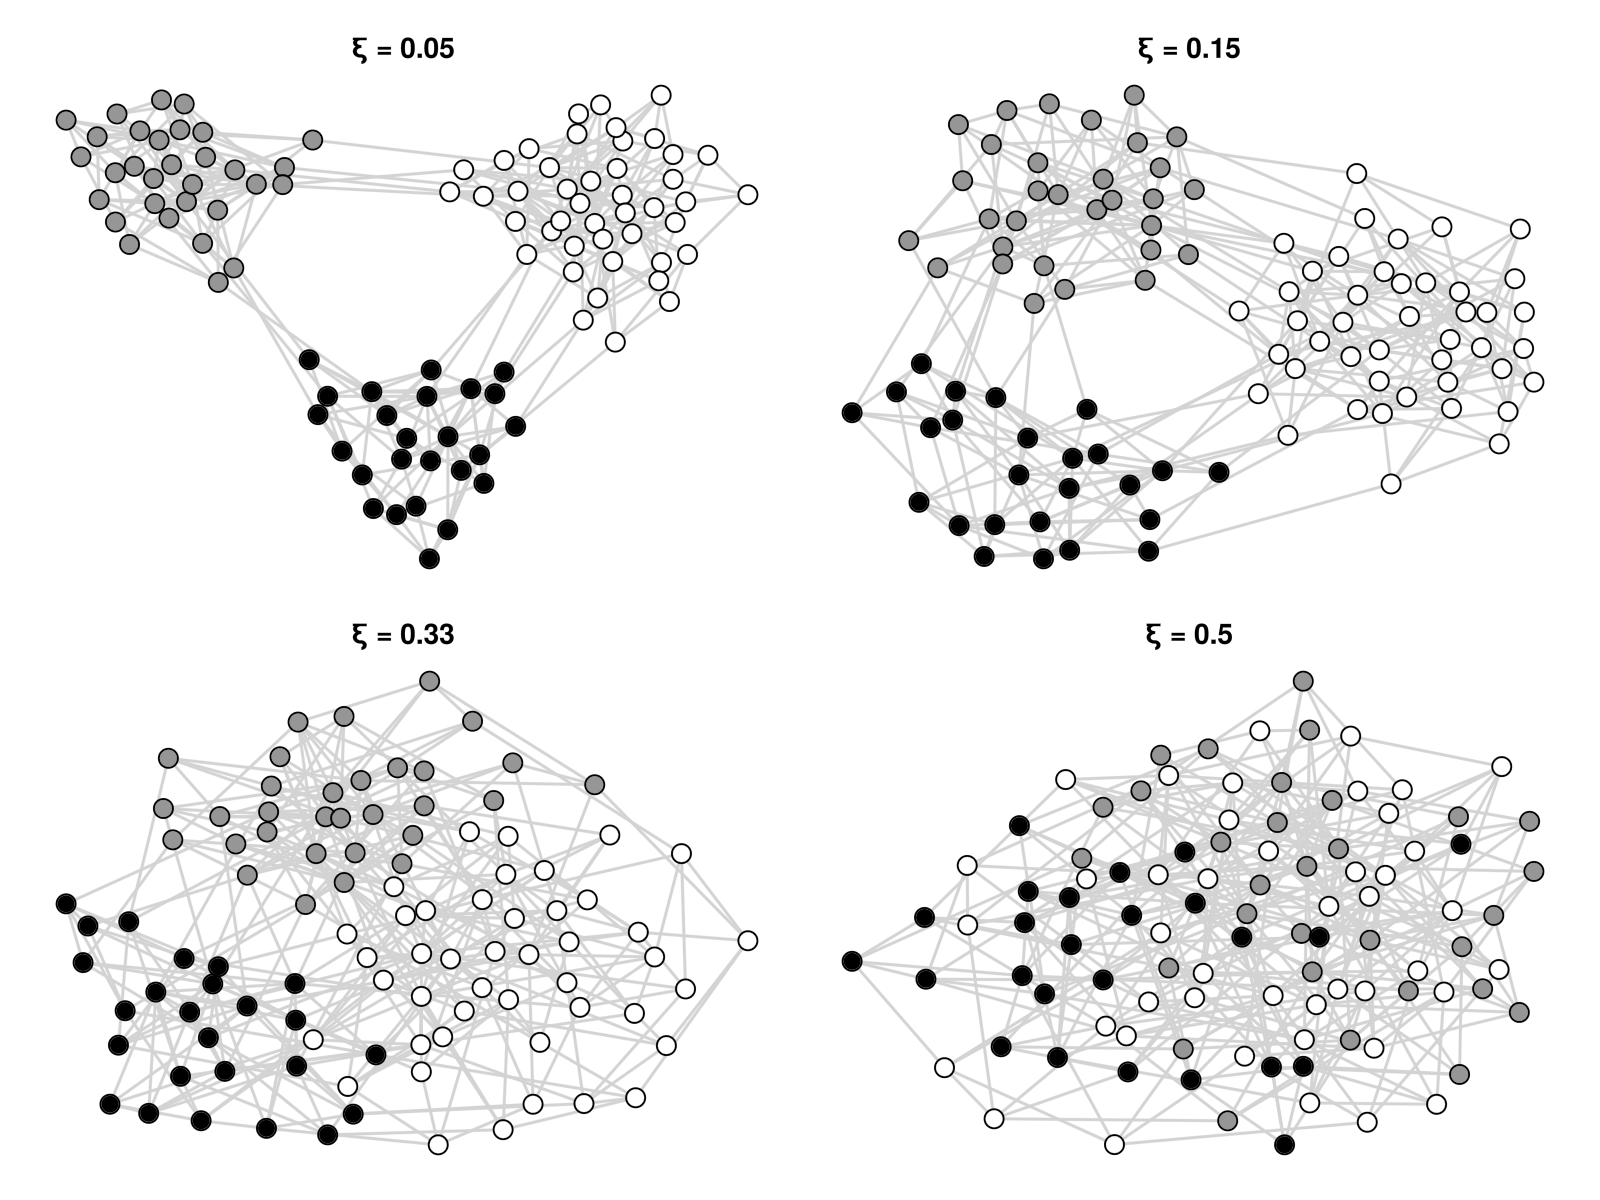

In [22]:
fig = Makie.Figure(size=(800, 600))
for i in 1:length(XIs)
    ax, plt = graphplot(
        fig[i <= 2 ? 1 : 2, in(i, [1, 3]) ? 1 : 2],
        g_abcds_xi[i][1],
        node_strokewidth=1,
        node_size=12,
        node_color=g_abcds_xi[i][2],
        node_attr=(colormap=:Greys,),
        edge_color=:lightgray
    )
    hidedecorations!(ax)
    hidespines!(ax)
    ax.title = "ξ = $(XIs[i]) "
end
fig

# ABCD with varying $\xi$ -- Experiments

Here we show a typical way to compare graph clustering algorithms using benchmark graphs. 
We pick some model, here ABCD, and we vary the noise parameter $\xi$. 
With ABCD, the larger $\xi$ is, the closer we are to a random Chung-Lu or configuration model graph (i.e. where only the degree distribution matters). For $\xi=0$, we get pure communities (all edges are internal).

For each choice of $\xi$, we generate 30 graphs, apply several different clustering algorithms,
and compute AMI (adjusted mutual information) for each algorithm, comparing with ground-truth communities.

The code below is commented out as it can take a while to run; saved results are included in the Data directory. To re-run from scratch, uncomment the cell below.

Parameters for the ABCD benchmark graphs are:

* $n=1,000$
* $\gamma=2.5$
* $\tau=1.5$
* degree range [10,50]
* community size range [50,100]
* $0.3 \le \xi \le 0.8$

We plot the results below. 
We see good results with Leiden and Infomap, and slightly better results with ECG.
Label propagation is a fast algortihm, but it does collapse with moderate to high level of noise.

From the standard deviation plot, we see high variability around the value(s) for $\xi$ where the different
algorithms start to collapse. We see that this happen later and at a smaller scale with EGC, which is known to have good stability.

ECG and Leiden are often good choices for *unweighted* graphs while for *weighted* graphs, Leiden is usually a good option.

Such studies are useful to compare algorithms; using benchmarks, we can directly control parameters such as the noise level.

Uncomment the cell below to re-run all the experiments (can take 4-5 minutes), otherwise we load the results in the next cell.

In [23]:
## common ABCD graph parameters

n = 1000

## degrees
gamma = 2.5
delta_min = 10
delta_max = 50

## communities
beta = 1.5
s_min = 50
s_max = 100

## generate the graphs and run various clustering algorithms
Random.seed!(42)
repetitions = 20
df = DataFrame(xi=Float64[],leiden=Float64[],ecg=Float64[],infomap=Float64[],lp=Float64[])
for xi in .3:.02:.801
    println(xi)
    for rep in 1:repetitions
        println("\t", rep)
        V = [xi]
        degs = ABCDGraphGenerator.sample_degrees(gamma, delta_min, delta_max, n, 1000)
        coms = ABCDGraphGenerator.sample_communities(beta, s_min, s_max, n, 1000)
        p = ABCDGraphGenerator.ABCDParams(degs, coms, nothing, xi, false, false, false)
        edges, clusters = ABCDGraphGenerator.gen_graph(p)

        g = ig.Graph()
        g.add_vertices(n)
        g.add_edges([(src - 1, dst - 1) for (src, dst) in edges])
        # Run clustering algorithms
        leiden=mutualinfo(pyconvert(Vector, g.community_leiden(objective_function="modularity").membership), clusters)
        ecg=mutualinfo(pyconvert(Vector, g.community_ecg(ens_size=16, final="leiden").membership), clusters)
        infomap=mutualinfo(pyconvert(Vector, g.community_infomap().membership), clusters)
        lp=mutualinfo(pyconvert(Vector, g.community_label_propagation().membership), clusters)
        push!(df,(;xi,leiden,ecg,infomap,lp))
    end
end
serialize("abcd_python_study_jl.ser", df)

0.3
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.32
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.34
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.36
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.38
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.4
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.42
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.44
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.46
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.48
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.5
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.52
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.54
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
0.56
	1
	2
	3
	

In [24]:
## load data generated with the code from above cell
df = deserialize("abcd_python_study_jl.ser");

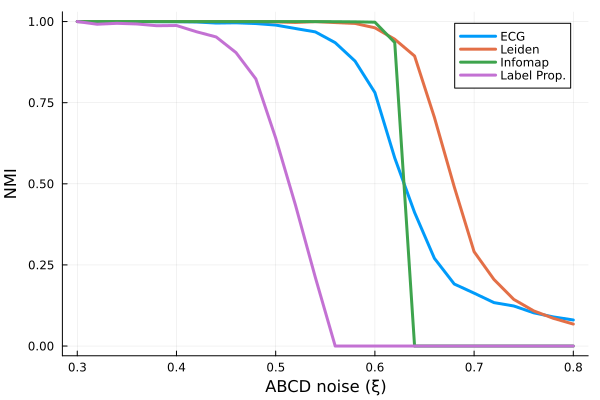

In [25]:
## mean
results_df = combine(groupby(df, "xi"), Not(:xi) .=> mean)
Plots.plot(results_df.xi, results_df.ecg_mean, lw=3, label="ECG", xlabel="ABCD noise (ξ)", ylabel="NMI")
Plots.plot!(results_df.xi, results_df.leiden_mean, lw=3, label="Leiden")
Plots.plot!(results_df.xi, results_df.infomap_mean, lw=3, label="Infomap")
Plots.plot!(results_df.xi, results_df.lp_mean, lw=3, label="Label Prop.")

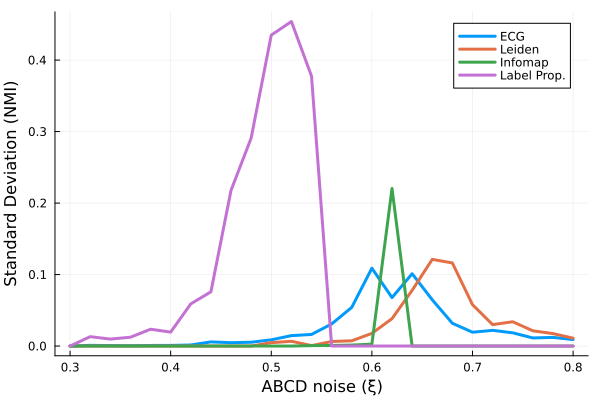

In [26]:
## standard deviation
results_df = combine(groupby(df, "xi"), Not(:xi) .=> std)
Plots.plot(results_df.xi, results_df.ecg_std, lw=3, label="ECG", xlabel="ABCD noise (ξ)", ylabel="Standard Deviation (NMI)")
Plots.plot!(results_df.xi, results_df.leiden_std, lw=3, label="Leiden")
Plots.plot!(results_df.xi, results_df.infomap_std, lw=3, label="Infomap")
Plots.plot!(results_df.xi, results_df.lp_std, lw=3, label="Label Prop.")